<a href="https://colab.research.google.com/github/akshayiitr04/satellite-property-valuation/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import os

os.chdir("/content/drive/MyDrive/satellite_project")
print(os.getcwd())


/content/drive/MyDrive/satellite_project


In [36]:
os.listdir()


['data',
 'images',
 'data_fetcher.py',
 '__pycache__',
 'preprocessing.ipynb',
 'best_model.pth',
 'model_training.ipynb']

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [38]:
!pip install mercantile pillow requests

In [39]:
!ls /content/drive/MyDrive/satellite_project

best_model.pth	data_fetcher.py  model_training.ipynb  __pycache__
data		images		 preprocessing.ipynb


In [40]:
from data_fetcher import save_satellite_image

# save_satellite_image(
#     image_id="house_003",
#     lat=48.1593,
#     lon=-122.5192
# )

hello
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#DOWNLOADING IMAGE FOR TRAIN DATA

In [41]:
train = pd.read_csv("/content/drive/MyDrive/satellite_project/data/processed/train_processed.csv")
train.shape


(16206, 17)

In [42]:
train.head()

,id,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_lot15,house_age,is_renovated,zipcode_te
0,9117000170,12.501142,4,2.25,2.0,0,0,3,7,7.501634,0.00000,47.4362,-122.187,9.131405,54,0,12.628271
1,6700390210,12.409018,3,2.50,2.0,0,0,4,7,7.378384,0.00000,47.4034,-122.187,8.190354,22,0,12.621663
2,7212660540,12.206078,4,2.50,2.0,0,0,3,8,7.450661,0.00000,47.2704,-122.313,8.916774,21,0,12.579669
3,8562780200,12.772806,2,2.25,2.0,0,0,3,7,7.048386,4.51086,47.5321,-122.073,6.621406,6,0,13.335357
4,7760400350,12.354497,3,2.00,1.0,0,0,3,7,7.155396,0.00000,47.3715,-122.074,8.996157,20,0,12.657948


In [ ]:
for _, row in train.iterrows():
    lati = row["lat"]
    longi = row["long"]
    image_id = row["id"]
    path = save_satellite_image(int(image_id),lati,longi )

# def save_satellite_image(image_id, lat, lon,
#                          base_dir="/content/drive/MyDrive/satellite_project/images/raw",
#                          zoom=19, tiles_across=3):


Streaming output truncated to the last 5000 lines.
Image 1826049430 already exists. Skipping.
Image 6641020050 already exists. Skipping.
Image 3221069057 already exists. Skipping.
Image 7922900380 already exists. Skipping.
Image 6073200075 already exists. Skipping.
Image 3885801190 already exists. Skipping.
Image 2781270080 already exists. Skipping.
Image 7215730590 already exists. Skipping.
Image 546000020 already exists. Skipping.
Image 8731960540 already exists. Skipping.
Image 1180003435 already exists. Skipping.
Image 2822069078 already exists. Skipping.
Image 7856610200 already exists. Skipping.
Image 3110800030 already exists. Skipping.
Image 2460700260 already exists. Skipping.
Image 272000355 already exists. Skipping.
Image 9432900040 already exists. Skipping.
Image 5062300280 already exists. Skipping.
Image 7519000570 already exists. Skipping.
Image 5029451080 already exists. Skipping.
Image 6795100330 already exists. Skipping.
Image 3303980210 already exists. Skipping.
Image

#FETCHING IMAGE FOR TEST DATA

In [43]:
test = pd.read_csv("/content/drive/MyDrive/satellite_project/data/processed/test_processed.csv")
test.shape

(5404, 16)

In [44]:
test.head()

,id,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_lot15,house_age,is_renovated,zipcode_te
0,2591820310,4,2.25,2.0,0,0,4,8,7.635787,0.000000,47.4388,-122.162,8.949105,28,0,12.753140
1,7974200820,5,3.00,1.0,0,0,5,8,7.512618,6.976348,47.6784,-122.285,8.745762,37,0,13.336040
2,7701450110,4,2.50,2.0,0,2,3,11,8.235095,0.000000,47.5646,-122.129,9.178437,17,0,13.684213
3,9522300010,3,3.50,2.0,0,2,3,12,8.425297,0.000000,47.6995,-122.228,9.562897,25,0,13.153954
4,9510861140,3,2.50,2.0,0,0,3,9,7.844241,0.000000,47.6647,-122.083,8.306719,10,0,13.385821


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404 entries, 0 to 5403
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             5404 non-null   int64  
 1   bedrooms       5404 non-null   int64  
 2   bathrooms      5404 non-null   float64
 3   floors         5404 non-null   float64
 4   waterfront     5404 non-null   int64  
 5   view           5404 non-null   int64  
 6   condition      5404 non-null   int64  
 7   grade          5404 non-null   int64  
 8   sqft_above     5404 non-null   float64
 9   sqft_basement  5404 non-null   float64
 10  lat            5404 non-null   float64
 11  long           5404 non-null   float64
 12  sqft_lot15     5404 non-null   float64
 13  house_age      5404 non-null   int64  
 14  is_renovated   5404 non-null   int64  
 15  zipcode_te     5404 non-null   float64
dtypes: float64(8), int64(8)
memory usage: 675.6 KB


In [ ]:
for _, row in train.iterrows():
    lati = row["lat"]
    longi = row["long"]
    image_id = row["id"]
    path = save_satellite_image(int(image_id), lati, longi,  base_dir="/content/drive/MyDrive/satellite_project/images/processed")


Streaming output truncated to the last 5000 lines.
Saved image 2205500540
Saved image 2493200015
Saved image 7853361420
Saved image 5652600605
Saved image 5285200020
Saved image 9406530150
Saved image 5706300020
Saved image 3278602490
Saved image 7197000100
Saved image 4447300008
Saved image 7899800045
Saved image 9250900095
Saved image 9268851740
Saved image 8682261440
Saved image 7284900385
Saved image 8079040300
Saved image 2225300585
Saved image 3223039013
Saved image 2013801350
Saved image 4055701110
Saved image 3578401770
Saved image 4046500720
Saved image 6145601745
Saved image 5207200195
Saved image 1972201856
Saved image 7212680080
Saved image 7277100510
Saved image 522079022
Saved image 5605000440
Saved image 6632300230
Saved image 8815400165
Saved image 6708200320
Saved image 2426059076
Saved image 3260200200
Saved image 2770601741
Saved image 4338800500
Saved image 9201000320
Saved image 7655900038
Saved image 3625059140
Saved image 4222310010
Saved image 2114700115
Saved i

In [ ]:

for i, row in test.head(5).iterrows():
    lati = row["lat"]
    longi = row["long"]
    image_id = row["id"]

    path = save_satellite_image(int(image_id), lati, longi,  base_dir="/content/drive/MyDrive/satellite_project/images/processed")

Saved image 2591820310
Saved image 7974200820
Saved image 7701450110
Saved image 9522300010
Saved image 9510861140


#Training loop for the multimodal model.

In [45]:
!pip install torch torchvision pandas scikit-learn tqdm

In [46]:
!cp -r /content/drive/MyDrive/satellite_project/images /content/images


In [47]:
!ls /content/images | head


images
processed
raw


In [48]:
!ls /content/images/raw | head
!ls /content/images/processed | head


1000102.jpg
1001200050.jpg
1003000175.jpg
100300280.jpg
100300530.jpg
1003400155.jpg
1003400245.jpg
1003400250.jpg
1003600056.jpg
1003600080.jpg
1000102.jpg
100100050.jpg
1001200035.jpg
100300500.jpg
1005000036.jpg
1005000220.jpg
1005000240.jpg
100600320.jpg
100600860.jpg
1020069017.jpg


In [49]:
# Directoriezzs
DATA_DIR  = "/content/drive/MyDrive/satellite_project/data/processed"

# Data
train_df = pd.read_csv(f"{DATA_DIR}/train_processed.csv")
test_df  = pd.read_csv(f"{DATA_DIR}/test_processed.csv")

TARGET_COL = "price"
ID_COL = "id"
IMAGE_COL = "image_path"

TRAIN_IMAGE_DIR = "/content/images/raw"

train_df["image_path"] = train_df["id"].astype(str).apply(
    lambda x: f"{TRAIN_IMAGE_DIR}/{x}.jpg"
)


TEST_IMAGE_DIR = "/content/images/processed"

test_df["image_path"] = test_df["id"].astype(str).apply(
    lambda x: f"{TEST_IMAGE_DIR}/{x}.jpg"
)


In [50]:
import os

print(train_df["image_path"].iloc[0])
print(os.path.exists(train_df["image_path"].iloc[0]))

print(test_df["image_path"].iloc[0])
print(os.path.exists(test_df["image_path"].iloc[0]))


/content/images/raw/9117000170.jpg
True
/content/images/processed/2591820310.jpg
True


In [51]:
X = train_df.copy()
y = train_df[TARGET_COL]

X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)
y_train = X_train[TARGET_COL]
y_val   = X_val[TARGET_COL]

train_image_paths = X_train[IMAGE_COL].tolist()
val_image_paths   = X_val[IMAGE_COL].tolist()

# Drop cols
TABULAR_DROP_COLS = [IMAGE_COL, ID_COL, TARGET_COL]

X_train_tab = X_train.drop(columns=TABULAR_DROP_COLS).values.astype("float32")
X_val_tab   = X_val.drop(columns=TABULAR_DROP_COLS).values.astype("float32")


In [52]:
class HousePriceDataset(Dataset):
    def __init__(self, df, tabular_data, transform=None):
        self.df = df.reset_index(drop=True)
        self.tabular_data = tabular_data
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, IMAGE_COL]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        tab = torch.tensor(self.tabular_data[idx], dtype=torch.float32)
        y   = torch.tensor(self.df.loc[idx, TARGET_COL], dtype=torch.float32)

        return image, tab, y


In [53]:
image_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_ds = HousePriceDataset(X_train, X_train_tab, image_transforms)
val_ds   = HousePriceDataset(X_val,   X_val_tab,   image_transforms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)


In [54]:
class CombinedModel(nn.Module):
    def __init__(self, tabular_dim):
        super().__init__()

        self.cnn = models.resnet18(weights="IMAGENET1K_V1")
        self.cnn.fc = nn.Identity()

        self.tabular_net = nn.Sequential(
            nn.Linear(tabular_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.regressor = nn.Sequential(
            nn.Linear(512 + 64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, image, tabular):
        img_feat = self.cnn(image)
        tab_feat = self.tabular_net(tabular)
        x = torch.cat([img_feat, tab_feat], dim=1)
        return self.regressor(x).squeeze(1)


In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CombinedModel(X_train_tab.shape[1]).to(device)

for param in model.cnn.parameters():
    param.requires_grad = False

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)

EPOCHS = 50
patience = 3
best_val_loss = float("inf")
counter = 0

train_mse_list = []
val_mse_list   = []

train_r2_list  = []
val_r2_list    = []

In [ ]:
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_preds, train_targets = [], []

    for imgs, tabs, targets in tqdm(train_loader):
        imgs, tabs, targets = imgs.to(device), tabs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(imgs, tabs).view(-1)
        targets = targets.view(-1)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(outputs.detach().cpu().numpy())
        train_targets.extend(targets.detach().cpu().numpy())

    train_loss /= len(train_loader)
    train_r2 = r2_score(train_targets, train_preds)

    # 🔥 STORE TRAIN METRICS
    train_mse_list.append(train_loss)
    train_r2_list.append(train_r2)

    # ---------- VALIDATION ----------
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []

    with torch.no_grad():
        for imgs, tabs, targets in val_loader:
            imgs, tabs, targets = imgs.to(device), tabs.to(device), targets.to(device)
            outputs = model(imgs, tabs).view(-1)
            targets = targets.view(-1)

            val_loss += criterion(outputs, targets).item()
            val_preds.extend(outputs.cpu().numpy())
            val_targets.extend(targets.cpu().numpy())

    val_loss /= len(val_loader)
    val_r2 = r2_score(val_targets, val_preds)

    # 🔥 STORE VAL METRICS
    val_mse_list.append(val_loss)
    val_r2_list.append(val_r2)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train MSE: {train_loss:.4f} | Train R²: {train_r2:.4f} | "
        f"Val MSE: {val_loss:.4f} | Val R²: {val_r2:.4f}"
    )

    # ---------- EARLY STOPPING ----------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("🛑 Early stopping triggered")
            break


100%|██████████| 406/406 [00:50<00:00,  8.12it/s]


Epoch 1/50 | Train MSE: 23.8623 | Train R²: -85.1927 | Val MSE: 0.6719 | Val R²: -1.5669


100%|██████████| 406/406 [00:51<00:00,  7.91it/s]


Epoch 2/50 | Train MSE: 0.6055 | Train R²: -1.1797 | Val MSE: 0.5698 | Val R²: -1.1801


100%|██████████| 406/406 [00:49<00:00,  8.13it/s]


Epoch 3/50 | Train MSE: 0.4994 | Train R²: -0.8016 | Val MSE: 0.4534 | Val R²: -0.7341


100%|██████████| 406/406 [00:53<00:00,  7.56it/s]


Epoch 4/50 | Train MSE: 0.3745 | Train R²: -0.3511 | Val MSE: 0.3234 | Val R²: -0.2383


100%|██████████| 406/406 [00:50<00:00,  8.08it/s]


Epoch 5/50 | Train MSE: 0.2671 | Train R²: 0.0357 | Val MSE: 0.2280 | Val R²: 0.1260


100%|██████████| 406/406 [00:51<00:00,  7.94it/s]


Epoch 6/50 | Train MSE: 0.2057 | Train R²: 0.2594 | Val MSE: 0.1838 | Val R²: 0.2945


100%|██████████| 406/406 [00:49<00:00,  8.20it/s]


Epoch 7/50 | Train MSE: 0.1715 | Train R²: 0.3810 | Val MSE: 0.1583 | Val R²: 0.3919


100%|██████████| 406/406 [00:50<00:00,  8.01it/s]


Epoch 8/50 | Train MSE: 0.1529 | Train R²: 0.4532 | Val MSE: 0.1524 | Val R²: 0.4144


100%|██████████| 406/406 [00:50<00:00,  8.02it/s]


Epoch 9/50 | Train MSE: 0.1370 | Train R²: 0.5056 | Val MSE: 0.1275 | Val R²: 0.5100


100%|██████████| 406/406 [00:52<00:00,  7.74it/s]


Epoch 10/50 | Train MSE: 0.1250 | Train R²: 0.5486 | Val MSE: 0.1186 | Val R²: 0.5441


100%|██████████| 406/406 [00:56<00:00,  7.17it/s]


Epoch 11/50 | Train MSE: 0.1169 | Train R²: 0.5794 | Val MSE: 0.1125 | Val R²: 0.5677


100%|██████████| 406/406 [00:51<00:00,  7.94it/s]


Epoch 12/50 | Train MSE: 0.1102 | Train R²: 0.6024 | Val MSE: 0.1065 | Val R²: 0.5906


100%|██████████| 406/406 [00:51<00:00,  7.82it/s]


Epoch 13/50 | Train MSE: 0.1035 | Train R²: 0.6275 | Val MSE: 0.0986 | Val R²: 0.6211


100%|██████████| 406/406 [00:50<00:00,  7.97it/s]


Epoch 14/50 | Train MSE: 0.0981 | Train R²: 0.6467 | Val MSE: 0.0980 | Val R²: 0.6235


100%|██████████| 406/406 [00:50<00:00,  7.99it/s]


Epoch 15/50 | Train MSE: 0.0920 | Train R²: 0.6681 | Val MSE: 0.0898 | Val R²: 0.6553


100%|██████████| 406/406 [00:51<00:00,  7.83it/s]


Epoch 16/50 | Train MSE: 0.0900 | Train R²: 0.6760 | Val MSE: 0.0880 | Val R²: 0.6619


100%|██████████| 406/406 [00:50<00:00,  8.01it/s]


Epoch 17/50 | Train MSE: 0.0863 | Train R²: 0.6888 | Val MSE: 0.0873 | Val R²: 0.6652


100%|██████████| 406/406 [00:51<00:00,  7.90it/s]


Epoch 18/50 | Train MSE: 0.0846 | Train R²: 0.6947 | Val MSE: 0.0819 | Val R²: 0.6857


100%|██████████| 406/406 [00:50<00:00,  8.12it/s]


Epoch 19/50 | Train MSE: 0.0809 | Train R²: 0.7081 | Val MSE: 0.0916 | Val R²: 0.6484


100%|██████████| 406/406 [00:50<00:00,  7.99it/s]


Epoch 20/50 | Train MSE: 0.0801 | Train R²: 0.7120 | Val MSE: 0.0902 | Val R²: 0.6536


100%|██████████| 406/406 [00:51<00:00,  7.85it/s]


Epoch 21/50 | Train MSE: 0.0785 | Train R²: 0.7182 | Val MSE: 0.0796 | Val R²: 0.6948


100%|██████████| 406/406 [00:50<00:00,  8.09it/s]


Epoch 22/50 | Train MSE: 0.0769 | Train R²: 0.7228 | Val MSE: 0.0765 | Val R²: 0.7064


100%|██████████| 406/406 [00:52<00:00,  7.78it/s]


Epoch 23/50 | Train MSE: 0.0759 | Train R²: 0.7261 | Val MSE: 0.0817 | Val R²: 0.6864


100%|██████████| 406/406 [00:49<00:00,  8.18it/s]


Epoch 24/50 | Train MSE: 0.0755 | Train R²: 0.7277 | Val MSE: 0.0738 | Val R²: 0.7166


100%|██████████| 406/406 [00:51<00:00,  7.86it/s]


Epoch 25/50 | Train MSE: 0.0730 | Train R²: 0.7369 | Val MSE: 0.0733 | Val R²: 0.7186


100%|██████████| 406/406 [00:49<00:00,  8.12it/s]


Epoch 26/50 | Train MSE: 0.0730 | Train R²: 0.7369 | Val MSE: 0.0759 | Val R²: 0.7085


100%|██████████| 406/406 [00:51<00:00,  7.93it/s]


Epoch 27/50 | Train MSE: 0.0723 | Train R²: 0.7391 | Val MSE: 0.0716 | Val R²: 0.7253


100%|██████████| 406/406 [00:49<00:00,  8.16it/s]


Epoch 28/50 | Train MSE: 0.0714 | Train R²: 0.7424 | Val MSE: 0.0812 | Val R²: 0.6888


100%|██████████| 406/406 [00:50<00:00,  7.98it/s]


Epoch 29/50 | Train MSE: 0.0705 | Train R²: 0.7484 | Val MSE: 0.0741 | Val R²: 0.7156


100%|██████████| 406/406 [00:49<00:00,  8.27it/s]


Epoch 30/50 | Train MSE: 0.0693 | Train R²: 0.7507 | Val MSE: 0.0697 | Val R²: 0.7325


100%|██████████| 406/406 [00:52<00:00,  7.73it/s]


Epoch 31/50 | Train MSE: 0.0677 | Train R²: 0.7559 | Val MSE: 0.0695 | Val R²: 0.7333


100%|██████████| 406/406 [00:49<00:00,  8.16it/s]


Epoch 32/50 | Train MSE: 0.0679 | Train R²: 0.7551 | Val MSE: 0.0684 | Val R²: 0.7373


100%|██████████| 406/406 [00:52<00:00,  7.80it/s]


Epoch 33/50 | Train MSE: 0.0679 | Train R²: 0.7557 | Val MSE: 0.0692 | Val R²: 0.7342


100%|██████████| 406/406 [00:50<00:00,  8.10it/s]


Epoch 34/50 | Train MSE: 0.0665 | Train R²: 0.7602 | Val MSE: 0.0686 | Val R²: 0.7367


100%|██████████| 406/406 [00:49<00:00,  8.13it/s]


Epoch 35/50 | Train MSE: 0.0662 | Train R²: 0.7613 | Val MSE: 0.0703 | Val R²: 0.7304
🛑 Early stopping triggered


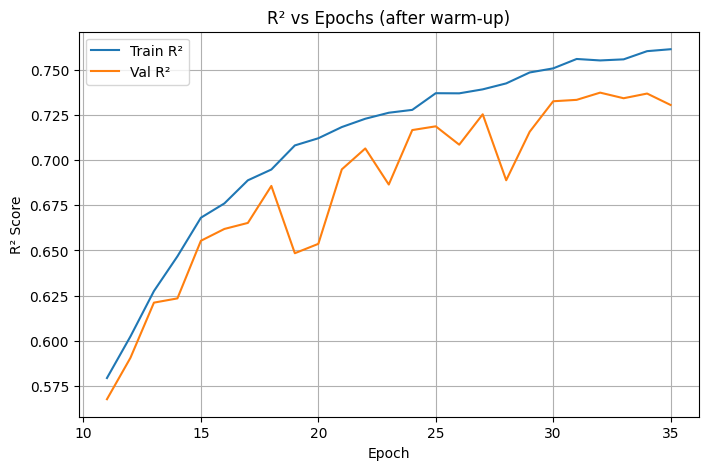

In [ ]:
skip = 10  # ignore first 10 epochs

epochs = range(skip + 1, len(train_r2_list) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_r2_list[skip:], label="Train R²")
plt.plot(epochs, val_r2_list[skip:], label="Val R²")

plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("R² vs Epochs (after warm-up)")
plt.legend()
plt.grid(True)
plt.show()


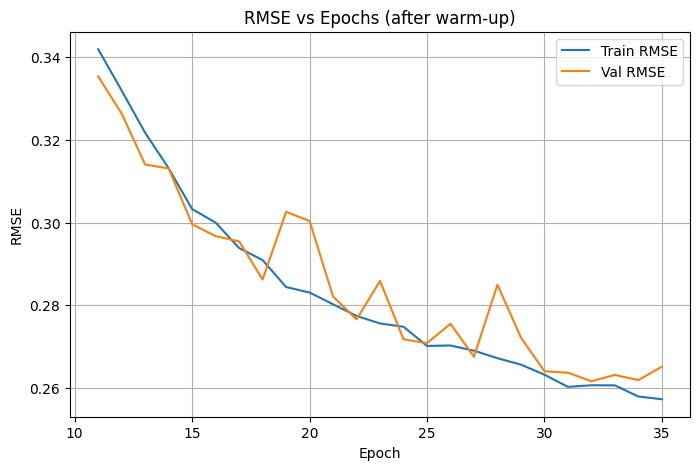

In [ ]:
train_rmse = [np.sqrt(mse) for mse in train_mse_list]
val_rmse   = [np.sqrt(mse) for mse in val_mse_list]

epochs = range(skip + 1, len(train_rmse) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_rmse[skip:], label="Train RMSE")
plt.plot(epochs, val_rmse[skip:], label="Val RMSE")

plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE vs Epochs (after warm-up)")
plt.legend()
plt.grid(True)
plt.show()


#Testing the model

In [71]:
from torch.utils.data import DataLoader

# Prepare test dataset and dataloader
test_tab_data = test_df.drop(columns=[ID_COL, IMAGE_COL]).values.astype("float32")

# Add a dummy TARGET_COL to test_df to satisfy HousePriceDataset's __getitem__
# The actual value doesn't matter as it's ignored in the test_loader loop
if TARGET_COL not in test_df.columns:
    test_df[TARGET_COL] = 0.0 # Placeholder value

test_ds = HousePriceDataset(test_df, test_tab_data, image_transforms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
model.to(device)

# Make predictions on test data
test_preds = []
with torch.no_grad():
    for imgs, tabs, _ in test_loader:
        imgs, tabs = imgs.to(device), tabs.to(device)
        outputs = model(imgs, tabs)
        test_preds.extend(outputs.cpu().numpy())

# Add predictions to test_df
test_df["predicted_price"] = test_preds

In [72]:
test_df.head()

,id,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_lot15,house_age,is_renovated,zipcode_te,image_path,price,predicted_price
0,2591820310,4,2.25,2.0,0,0,4,8,7.635787,0.000000,47.4388,-122.162,8.949105,28,0,12.753140,/content/images/processed/2591820310.jpg,0.0,12.994825
1,7974200820,5,3.00,1.0,0,0,5,8,7.512618,6.976348,47.6784,-122.285,8.745762,37,0,13.336040,/content/images/processed/7974200820.jpg,0.0,13.509711
2,7701450110,4,2.50,2.0,0,2,3,11,8.235095,0.000000,47.5646,-122.129,9.178437,17,0,13.684213,/content/images/processed/7701450110.jpg,0.0,13.969395
3,9522300010,3,3.50,2.0,0,2,3,12,8.425297,0.000000,47.6995,-122.228,9.562897,25,0,13.153954,/content/images/processed/9522300010.jpg,0.0,14.241956
4,9510861140,3,2.50,2.0,0,0,3,9,7.844241,0.000000,47.6647,-122.083,8.306719,10,0,13.385821,/content/images/processed/9510861140.jpg,0.0,13.342177


In [73]:
import numpy as np
import pandas as pd

# Assuming `test_df` now has a column `predicted_price` in the log scale
test_df["predicted_price_original"] = np.exp(test_df["predicted_price"])

# Prepare final CSV with required format
submission_df = test_df[[ID_COL, "predicted_price_original"]].rename(
    columns={"predicted_price_original": "predicted_price"}
)

# Save to CSV
submission_df.to_csv("price_predictions.csv", index=False)
print("✅ Prediction file saved: price_predictions.csv")


✅ Prediction file saved: price_predictions.csv


In [74]:
# Define folder path
output_dir = "/content/drive/MyDrive/satellite_project"

# Make sure the folder exists
import os
os.makedirs(output_dir, exist_ok=True)

# Save CSV in that folder
submission_path = os.path.join(output_dir, "price_predictions.csv")
submission_df.to_csv(submission_path, index=False)
print(f"✅ Prediction file saved at: {submission_path}")


✅ Prediction file saved at: /content/drive/MyDrive/satellite_project/price_predictions.csv
